<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for CNN-based Drainage Feature Object Detection<br> Using Faster RCNN</h1>

<p style="text-align:center;font-size:12px;">
<strong>Department of Geography and Environmental Resources, Southern Illinois University Carbondale, IL, USA</strong><br>

</p>
<h2 style="text-align:center;line-height:1.5em;font-size:30px;">Bounding Box Coordinates Processing</h2>
<hr>

**Notebook Structure**
<br> 

**Notebook Structure**
<br> 
 Codes   
 1. CNN  Model Development
 2. FRCNN Detection <br>
 3. Bounding Box Coordinates Processing**<br>
 4. Process the DEM using Least Cost Path  <br>
 5. Hydrological Streamline detection Using UNet <br>

** Indicates Active Notebook

***
### Bounding Box Coordinates Processing


This part of the code will convert the bounding boxes generated by the Faster RCNN model from Image based coordinate system to Projected coordinate system and saves the output as an ESRI shapefile.

This shapefile will then be used to clip the DEM raster for further processing.

***

### Run the block below to install required libraries

You have to restart the kernel after running the code block below. 


In [ ]:
# Install required libraries for processing.
# !pip install --user tifffile
# !pip install --user numpy
# !pip install --user pandas
# !pip install --user geopandas
# !pip install --user shapely

# Please restart the kernel after this block finished running.


<h1>Load the original DEM data</h1>

In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal, ogr


large_img = tiff.imread(./FRCNN_predict/images/site_test.tif")
print(large_img.shape) 


# plt.imshow(large_img)
# plt.axis()
# plt.show()

(4800, 4800)


<h3> Convert the bounding box coordinates from patch size to the big image</h3> 

In [2]:
import pandas as pd
import ast
import math

# Load the CSV data into a pandas DataFrame
df = pd.read_csv("../FRCNN_predict/patches_800/validation_results2.csv")

image_height = large_img.shape[0]
image_width = large_img.shape[1]
patch_size = 800
padding_height = (math.ceil(large_img.shape[0] / patch_size) * patch_size) - large_img.shape[0]
padding_width = (math.ceil(large_img.shape[1] / patch_size) * patch_size) - large_img.shape[1]
# Create empty lists to store the adjusted coordinates
x1_adjusted_list = []
x2_adjusted_list = []
y1_adjusted_list = []
y2_adjusted_list = []

# Iterate over each row in the DataFrame
for i, row in df.iterrows():
    # Check if the patch has detections   c
    if row['labels']:
        # Get the bounding box information
        labels = ast.literal_eval(row['labels'])
        if 'True' in labels:
            x1_values = row['x1'].strip("[]")
            x2_values = row['x2'].strip("[]")
            y1_values = row['y1'].strip("[]")
            y2_values = row['y2'].strip("[]")
            patch_name = row['file_name']
            patch_row, patch_col = map(int, patch_name.split("_")[3:])

            # Adjust the bounding box coordinates
            if not isinstance(x1_values, list):
                x1_values = [x1_values]
            if not isinstance(x2_values, list):
                x2_values = [x2_values]
            if not isinstance(y1_values, list):
                y1_values = [y1_values]
            if not isinstance(y2_values, list):
                y2_values = [y2_values]

            for j in range(len(x1_values)):
                # Calculate the starting pixel position of the patch within the entire padded image
                start_pixel_row = patch_row * patch_size
                start_pixel_col = patch_col * patch_size
                
#                 # Calculate the starting pixel position of the patch within the original image without padding
#                 start_pixel_row = start_pixel_row + padding_width
#                 start_pixel_col = start_pixel_col + padding_height
                
                
            # Determine appropriate handling based on the type of x1_values[j]
                x1_adjusted = [int(x) + start_pixel_col for x in x1_values[j].split(',')]
                x2_adjusted = [int(x) + start_pixel_col for x in x2_values[j].split(',')]
                y1_adjusted = [int(x) + start_pixel_row for x in y1_values[j].split(',')]
                y2_adjusted = [int(x) + start_pixel_row for x in y2_values[j].split(',')]

                # Handle the padding by clamping the coordinates to the original image dimensions
                x1_adjusted = [min(x, image_width) for x in x1_adjusted]
                x2_adjusted = [min(x, image_width) for x in x2_adjusted]
                y1_adjusted = [min(y, image_height) for y in y1_adjusted]
                y2_adjusted = [min(y, image_height) for y in y2_adjusted]

                # Append the adjusted coordinates to the respective lists
                x1_adjusted_list.append(x1_adjusted)
                x2_adjusted_list.append(x2_adjusted)
                y1_adjusted_list.append(y1_adjusted)
                y2_adjusted_list.append(y2_adjusted)

# Print the adjusted bounding box coordinate lists
print('x1_adjusted_list:', x1_adjusted_list)
print('x2_adjusted_list:', x2_adjusted_list)
print('y1_adjusted_list:', y1_adjusted_list)
print('y2_adjusted_list:', y2_adjusted_list)



x1_adjusted_list: [[1180, 1175], [4121], [368], [2869, 2784], [4003, 4669, 4388], [25], [1279, 802], [3243, 3458], [4075], [3238, 3669, 3241], [4076], [21, 679, 17], [811], [1625], [1206]]
x2_adjusted_list: [[1282, 1271], [4222], [465], [2964, 2885], [4102, 4775, 4486], [127], [1380, 886], [3341, 3562], [4174], [3338, 3768, 3345], [4173], [126, 777, 120], [914], [1728], [1312]]
y1_adjusted_list: [[373, 2], [739], [947], [1542, 1540], [1540, 1542, 1538], [2153], [1939, 1600], [1600, 2333], [1601], [2649, 3131, 3126], [3134], [3201, 3200, 3769], [3200], [3617], [4686]]
y2_adjusted_list: [[475, 52], [798], [1046], [1598, 1597], [1598, 1597, 1598], [2255], [2039, 1658], [1654, 2398], [1664], [2748, 3198, 3195], [3200], [3290, 3284, 3868], [3278], [3720], [4784]]


<h3> Visualize the bounding boxes on the large DEM </h3>

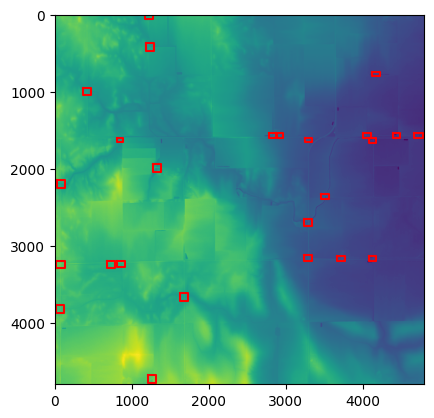

In [3]:
# Check to see that patch level coversion is done correctly
# x1_adjusted_list= [[38], [469], [41]]
# x2_adjusted_list= [[138], [568], [145]]
# y1_adjusted_list= [[249], [731], [726]]
# y2_adjusted_list= [[348], [798], [795]]

import matplotlib.pyplot as plt
import tifffile as tiff

larger_image = tiff.imread("../FRCNN_predict/images/site_test.tif")
# Assuming you have the larger image loaded or accessible
larger_image_width = larger_image.shape[0]
larger_image_height = larger_image.shape[1]

# Plot the larger image
plt.imshow(larger_image, grey )

# Plot the adjusted bounding boxes
for x1, x2, y1, y2 in zip(x1_adjusted_list, x2_adjusted_list, y1_adjusted_list, y2_adjusted_list):
    for i in range(len(x1)):
        plt.plot([x1[i], x2[i], x2[i], x1[i], x1[i]], [y1[i], y1[i], y2[i], y2[i], y1[i]], color='red')

# Set plot limits
plt.xlim(0, larger_image_width)
plt.ylim(larger_image_height, 0)  # Inverted y-axis for image coordinates

# Show the plot
plt.show()


<h3>Convert the bounding boxes to geographic coordnates</h3>

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from osgeo import osr, gdal


# x1_adjusted_list= [[38], [469], [41]]
# x2_adjusted_list= [[138], [568], [145]]
# y1_adjusted_list= [[249], [731], [726]]
# y2_adjusted_list= [[348], [798], [795]]
    
#Get Original Image Projection
org_img=gdal.Open("../FRCNN_predict/images/site_test.tif")
prj=org_img.GetProjection()

# Run gdalinfo command and capture the output
gdalinfo_dict = gdal.Info(org_img, options=['-json'])

# Extract the origin coordinates
origin = gdalinfo_dict['cornerCoordinates']['upperLeft']

# Access the individual coordinates
origin_x = origin[0]
origin_y = origin[1]
print(origin_x)
print(origin_y)
 
# origin_x = 543224.355
# origin_y = 4503820.252
# proj = 'PROJCS["NAD_1983_UTM_Zone_14N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26914"]]'
    
# Create a GeoDataFrame with the adjusted bounding box coordinates
bbox_data = {'x1': [], 'x2': [], 'y1': [], 'y2': []}
for x1, x2, y1, y2 in zip(x1_adjusted_list, x2_adjusted_list, y1_adjusted_list, y2_adjusted_list):
    bbox_data['x1'].extend(x1)
    bbox_data['x2'].extend(x2)
    bbox_data['y1'].extend(y1)
    bbox_data['y2'].extend(y2)
df = pd.DataFrame(bbox_data)
geometry = [box(x1, y1, x2, y2) for x1, x2, y1, y2 in zip(df['x1'], df['x2'], df['y1'], df['y2'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the CRS of the GeoDataFrame using the original image CRS
original_crs = osr.SpatialReference()
wkt_projection = prj
original_crs.SetFromUserInput(wkt_projection)  # Replace with the appropriate EPSG code for the original image CRS
gdf.crs = original_crs.ExportToProj4()

# Perform coordinate transformation to the original image CRS
target_crs = original_crs.ExportToProj4()
transformed_gdf = gdf.to_crs(target_crs)

# Adjust the transformed bounding box coordinates based on the original image origin
# transformed_x1 = transformed_gdf['geometry'].bounds['minx'] + origin_x
# transformed_x2 = transformed_gdf['geometry'].bounds['maxx'] + origin_x
# transformed_y1 =  origin_y - transformed_gdf['geometry'].bounds['miny'] 
# transformed_y2 = origin_y - transformed_gdf['geometry'].bounds['maxy']  
transformed_x1 = transformed_gdf['geometry'].bounds['minx'] + origin_x -1
transformed_x2 = transformed_x1 + 101
transformed_y1 =  origin_y - transformed_gdf['geometry'].bounds['miny'] 
transformed_y2 = transformed_y1 - 101 

# Print the transformed bounding box coordinates
print('Transformed Bounding Box Coordinates (CRS: {}):'.format(target_crs))
for i in range(len(transformed_x1)):
    print('BoundingBox {}:'.format(i+1))
    print('Min X:', transformed_x1[i])
    print('Max X:', transformed_x2[i])
    print('Min Y:', transformed_y1[i])
    print('Max Y:', transformed_y2[i])
    print()

<h3> Save each bounding box as an ESRI shapefile</h3>

In [16]:
##Convert Bbox to ESRI shapefile##

# Create a GeoDataFrame with the transformed bounding box coordinates
geometry = [box(x1, y1, x2, y2) for x1, x2, y1, y2 in zip(transformed_x1, transformed_x2, transformed_y1, transformed_y2)]
gdf_transformed = gpd.GeoDataFrame(geometry=geometry)
gdf_transformed.crs = target_crs

# Define the output shapefile path
output_shapefile = "../FRCNN_predict/patches_800/bbox4.shp"

# Save the GeoDataFrame as a shapefile
# gdf_transformed.to_file(output_shapefile)

# Reset the "FID" values to start from 1
gdf_transformed['FID'] = range(1, len(gdf_transformed) + 1)

# Save the updated GeoDataFrame to the same shapefile
gdf_transformed.to_file(output_shapefile)


<h3>Clip the original DEM to the shapefile</h3>
<h4>Generate DEM raster 100x100</h4>

In [ ]:
import os
from osgeo import gdal
from osgeo import ogr
import geopandas as gpd
from shapely.geometry import box

def clipDem(raster_fname, vector_fname, ifeat, output_dir):
    # Get the base filename without the directory path
    base_filename = os.path.basename(raster_fname)
    # New filename. Assumes input raster file has '.tif' extension
    fname_out = os.path.join(output_dir, base_filename.replace(".tif", f"_{ifeat}.tif"))
    # Do the actual clipping
    g = gdal.Warp(fname_out, raster_fname, format="GTiff",
                  cutlineDSName=vector_fname,
                  cutlineWhere=f"FID={ifeat}",
                  cropToCutline=True)
    
#     # Resample the clipped raster to 100x100 pixels
#     output_resampled = os.path.join(output_dir, base_filename.replace(".tif", f"_{ifeat}.TIF"))
#     gdal.Translate(output_resampled, g, width=100, height=100, resampleAlg="bilinear")
    g = None  # Close the dataset
    
    # Return the fname just because
    return fname_out

vector_fname = "../FRCNN_predict/patches_800/bbox4.shp"
raster_fname = "../FRCNN_predictimages/site_test.tif"
output_dir = "..FRCNN_predict/clipped_output1"  # Specify the output directory here

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Read the vector file as a GeoDataFrame
gdf = gpd.read_file(vector_fname)

# Loop over all features (polygons) in the GeoDataFrame
for index, feature in gdf.iterrows():
    ifeat = feature['FID']
    fname_out = clipDem(raster_fname, vector_fname, ifeat, output_dir)
    print(fname_out)


C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_1.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_2.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_3.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_4.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_5.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_6.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_7.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_8.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_9.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_10.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_11.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_12.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_predict\\clipped_output1\site_test_13.tif
C:\\Users\\mikeb\\Desktop\\FRCNN_p